# PBMC datasets - harmonize annotation

In this notebook I load the merged PBMC dataset with scVI latent dimensions and generate a unified annotation, to use for OOR simulation experiments.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os,sys
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import scipy
import anndata

import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

import q2r_uncertainty
import diff2atlas


Global seed set to 0


In [ ]:
import celltypist
import milopy

In [ ]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
library(tidyverse)
library(patchwork)

In [ ]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

### Load dataset

Built in `src/1_PBMC_data_processing/2_PBMC_scVI.ipynb`

In [ ]:
data_dir = '/home/jovyan/mount/gdrive/query2reference/PBMC_CZIintegration_data/'
adata = sc.read_h5ad(data_dir + 'PBMC_merged.normal.subsample500cells.scVI.h5ad')

In [ ]:
adata

AnnData object with n_obs × n_vars = 634000 × 5000
    obs: 'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'assay_ontology_term_id', 'sample_id', 'donor_id', 'dataset_id', 'development_stage', 'cell_type', 'n_counts', 'batch', '_scvi_batch', '_scvi_labels'
    var: 'gene_id', 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi', 'hvg', 'scVI', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'scVI_connectivities', 'scVI_distances'

In [ ]:
%%time
sc.tl.leiden(adata, resolution=1.5, neighbors_key='scVI', n_iterations=5)

CPU times: user 7min 55s, sys: 11.1 s, total: 8min 6s
Wall time: 8min 5s


In [ ]:
# adata.write_h5ad(data_dir + 'PBMC_merged.normal.subsample500cells.scVI.h5ad')

In [ ]:
# adata = sc.read_h5ad(data_dir + 'PBMC_merged.normal.subsample500cells.scVI.h5ad', backed=True)

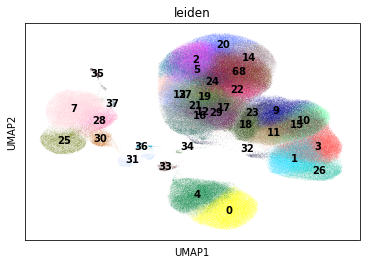

In [ ]:
sc.pl.umap(adata, color='leiden', legend_loc='on data')

In [ ]:
conf_mat = sc.metrics.confusion_matrix('leiden', 'cell_type', adata.obs)

In [ ]:
cell_type_leiden = dict(zip(conf_mat.index, conf_mat.idxmax(1)))
cell_type_leiden_frac = dict(zip(conf_mat.index, conf_mat.max(1)))

adata.obs['cell_type_leiden'] = [cell_type_leiden[x] for x in adata.obs['leiden']]
adata.obs['cell_type_leiden_frac'] = [cell_type_leiden_frac[x] for x in adata.obs['leiden']]

... storing 'cell_type_leiden' as categorical


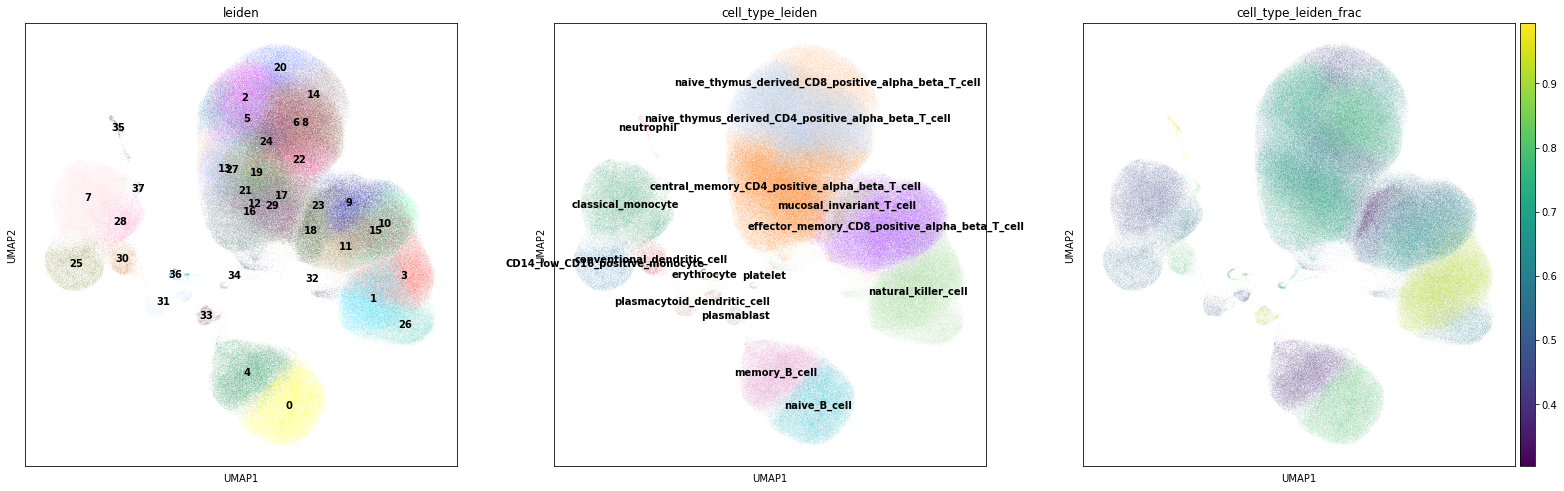

In [ ]:
with rc_context({'figure.figsize':[8,8]}):
    sc.pl.umap(adata, color=['leiden', 'cell_type_leiden', 'cell_type_leiden_frac'], legend_loc='on data')

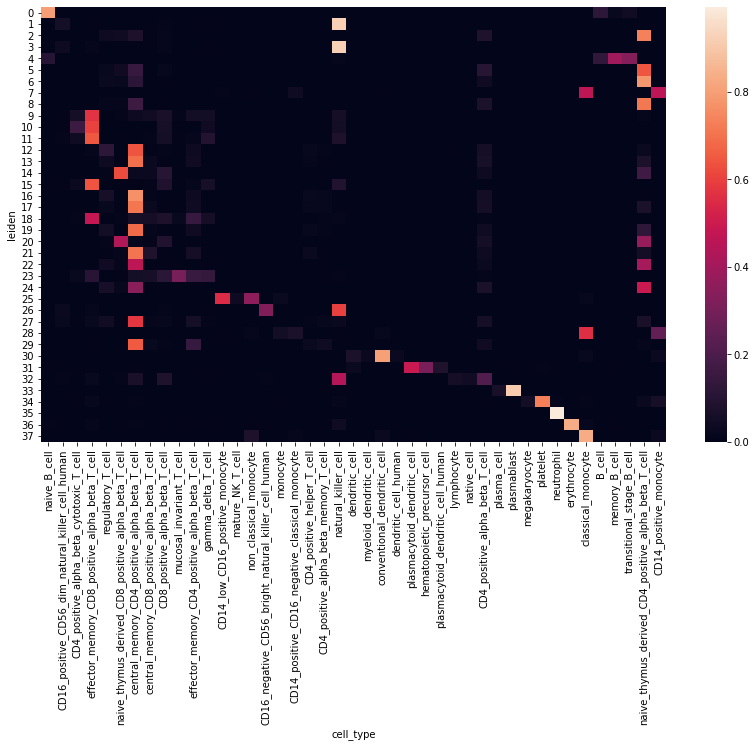

In [ ]:
conf_mat_plt = conf_mat.loc[:,conf_mat.max() > 0.025]
col_order = conf_mat_plt.idxmax(0).sort_values().index
with rc_context({'figure.figsize':[14,8]}):
    sns.heatmap(conf_mat_plt.loc[:,col_order])

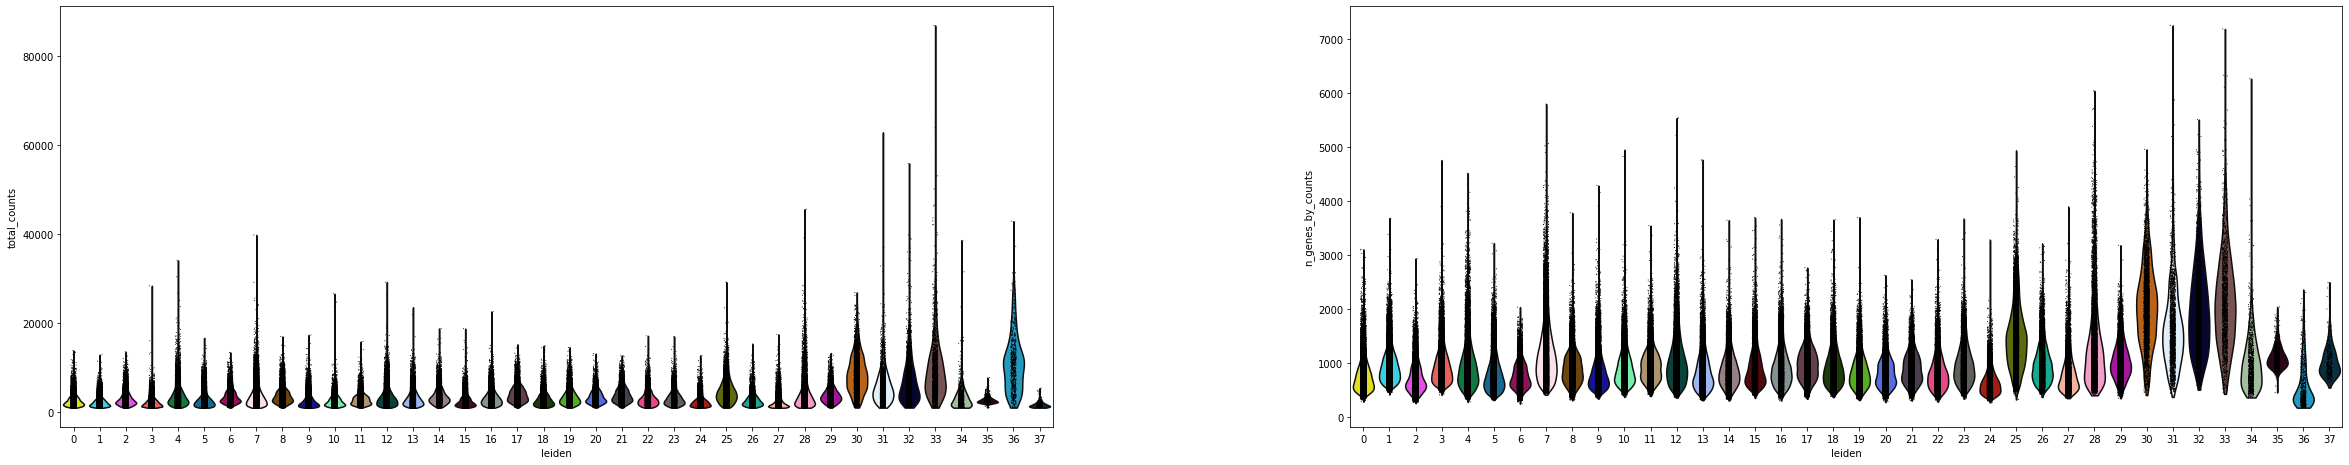

In [ ]:
with rc_context({'figure.figsize':[14,8]}):
    sc.pl.violin(adata, ['total_counts', 'n_genes_by_counts'],groupby='leiden')

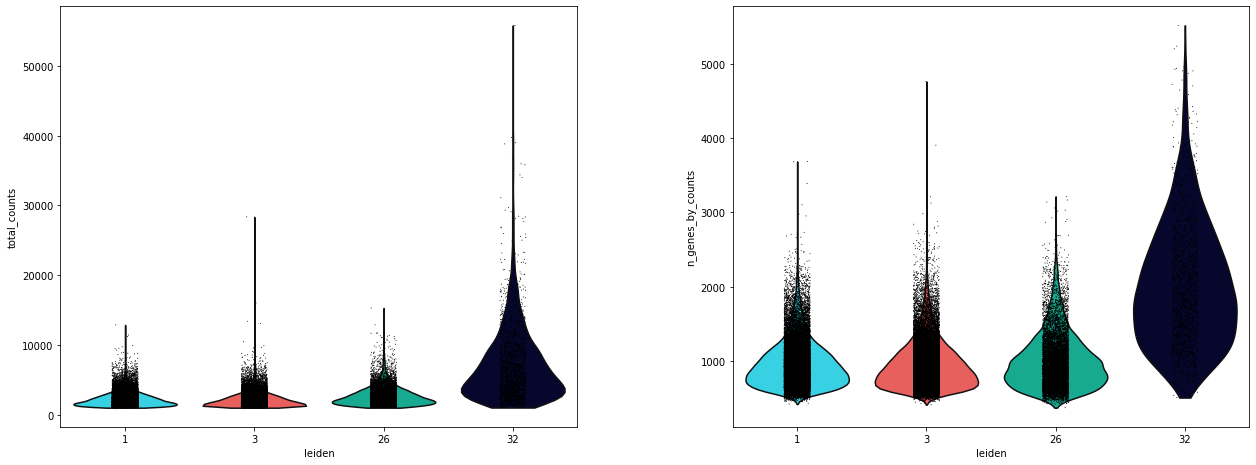

In [ ]:
with rc_context({'figure.figsize':[8,8]}):
    sc.pl.violin(adata[adata.obs['cell_type_leiden'] == 'natural_killer_cell'], ['total_counts', 'n_genes_by_counts'],groupby='leiden')

In [ ]:
## Remove low-quality (potentially doublet) cluster
adata = adata[adata.obs['leiden'] != '32'].copy()

In [ ]:
## Make version with fixed names for submitting jobs 
def clean_pop_name(string):
    clean = ''.join(e if e.isalnum() else '_' for e in string)
    return('_'.join(clean.split('__')))

adata.obs['cell_type'] = [clean_pop_name(x) for x in adata.obs['cell_type_leiden']]

### Save object for simulation experiments

In [ ]:
adata_full = sc.read_h5ad('/home/jovyan/mount/gdrive/query2reference/PBMC_CZIintegration_data/PBMC_merged.normal.subsample500cells.h5ad')

In [ ]:
adata_full

AnnData object with n_obs × n_vars = 634000 × 11724
    obs: 'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'assay_ontology_term_id', 'sample_id', 'donor_id', 'dataset_id', 'development_stage', 'cell_type'
    var: 'gene_id', 'gene_name'

In [ ]:
adata_full = adata_full[adata.obs_names].copy()
adata_full.obs = adata.obs.copy()
adata_full.obsm = adata.obsm.copy()

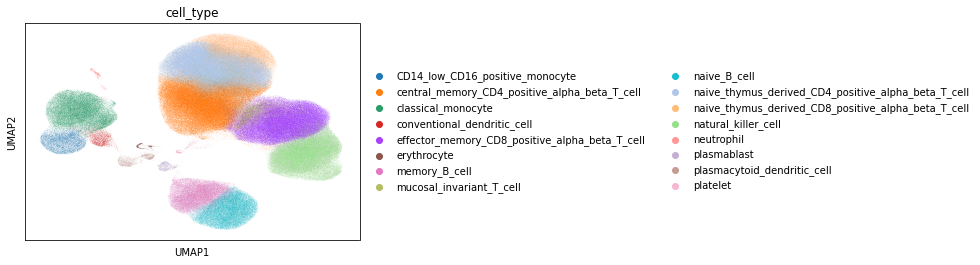

In [ ]:
sc.pl.umap(adata_full, color='cell_type')

In [ ]:
outdir = '/lustre/scratch126/cellgen/team205/ed6/PBMC_CZI_integration_filtered/'
adata_full.write_h5ad(outdir + 'PBMC_merged.normal.subsample500cells.clean_celltypes.h5ad')
outdir + 'PBMC_merged.normal.subsample500cells.clean_celltypes.h5ad'

In [ ]:
## Save list of celltypes
with open(outdir + 'PBMC_merged.normal.subsample500cells.clean_celltypes.txt', 'w') as f:
    for line in adata.obs['cell_type'].unique().tolist():
        f.write("%s\n" % line)

### Make plots for experiment design

In [ ]:
outdir = '/lustre/scratch126/cellgen/team205/ed6/PBMC_CZI_integration_filtered/'
adata_full = sc.read_h5ad(outdir + 'PBMC_merged.normal.subsample500cells.clean_celltypes.h5ad', backed=True)
adata_full

AnnData object with n_obs × n_vars = 597321 × 11724 backed at '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/PBMC_merged.normal.subsample500cells.clean_celltypes.h5ad'
    obs: 'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'assay_ontology_term_id', 'sample_id', 'donor_id', 'dataset_id', 'development_stage', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type_leiden', 'cell_type_leiden_frac'
    var: 'gene_id', 'gene_name'
    uns: 'cell_type_colors'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categoricals'

In [ ]:
import diff2atlas
query_dataset = ['10_1038_s41591_021_01329_2']
batch_obs = 'dataset_id'
population_obs = 'cell_type'
perturb_pop = ['naive_B_cell']
split_seed = 42

#  Select query batch
query = np.array([s in query_dataset for s in adata_full.obs[batch_obs]])
adata_full.obs["is_train"] = (~query).astype(int)
adata_full.obs["is_test"] = query.astype('int')

## Split in case and ctrl
np.random.seed(split_seed)
query_samples = adata_full.obs['sample_id'][adata_full.obs[batch_obs].isin(
    query_dataset)].unique()
samples_design = np.random.choice((0, 1), len(query_samples))
adata_full.obs['is_ctrl'] = adata_full.obs['sample_id'].isin(
    query_samples[samples_design == 1]).astype(int)
adata_full.obs.loc[adata_full.obs['is_ctrl'] == 1, 'is_test'] = 0

# Remove query-specific pop from ctrl and atlas
adata_full.obs.loc[(adata_full.obs[population_obs].isin(perturb_pop)),
              'is_train'] = 0
adata_full.obs.loc[(adata_full.obs[population_obs].isin(
    perturb_pop)), 'is_ctrl'] = 0

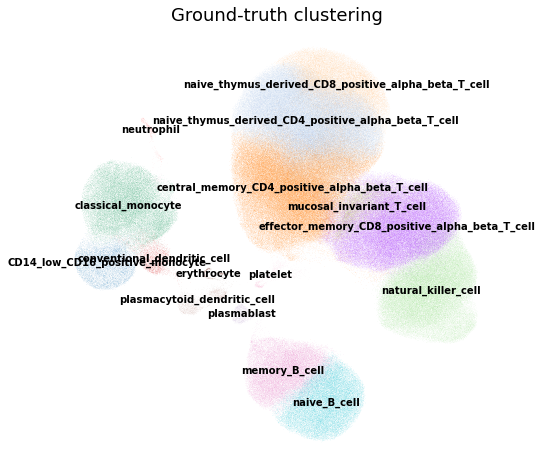

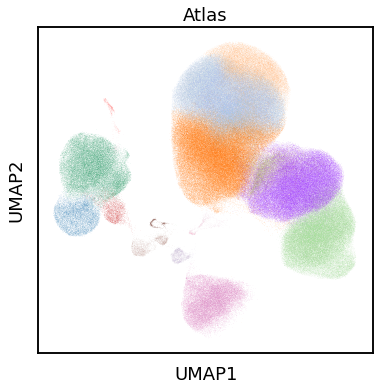

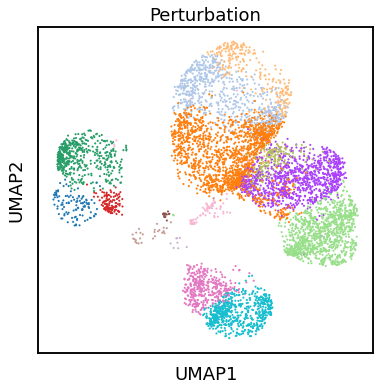

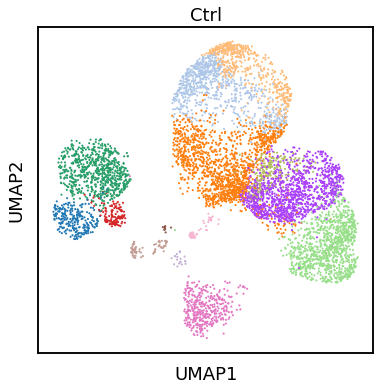

In [ ]:
sns.set_context('talk');
with rc_context({'figure.figsize':[8,8]}):
    sc.pl.umap(adata_full, color='cell_type', legend_loc = 'on data', title='Ground-truth clustering', legend_fontsize=10, frameon=False);
with rc_context({'figure.figsize':[6,6]}):
    sc.pl.umap(adata_full[adata_full.obs.is_train == 1], color='cell_type', legend_loc= 'none', title='Atlas');
    sc.pl.umap(adata_full[adata_full.obs.is_test == 1], color='cell_type', legend_loc= 'none', title='Perturbation');
    sc.pl.umap(adata_full[adata_full.obs.is_ctrl == 1], color='cell_type', legend_loc= 'none', title='Ctrl');

In [ ]:
## Plot number of donors and cells
donors_dict = {}
for subset in ['is_test','is_train', 'is_ctrl']:
    sdata = adata_full[adata_full.obs[subset] == 1]
    n_donors = sdata.obs['donor_id'].unique().shape[0]
    donors_dict[subset] = n_donors

In [ ]:
donors_dict

{'is_test': 13, 'is_train': 1219, 'is_ctrl': 16}

In [ ]:
adata_full.obs['dataset_id'].unique().shape

(13,)

---

In [ ]:
sample_obs = pd.read_csv('PBMC_sample_metadata.normal.csv')

In [ ]:
%%R -i sample_obs
dim(sample_obs)

[1] 1268   11


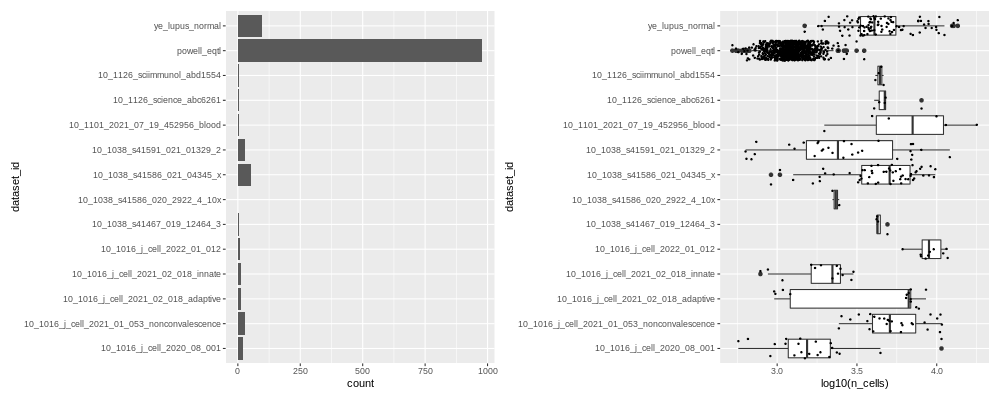

In [ ]:
%%R -w 1000 -h 400
sample_obs %>%
    ggplot(aes(dataset_id)) +
    geom_bar( ) +
    coord_flip() +
sample_obs %>%
ggplot(aes(dataset_id, log10(n_cells))) +
geom_boxplot() +
geom_jitter(size=0.5) +
scale_fill_viridis_c() +
coord_flip()